In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import *
from functorch import vmap
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

# Soft-Nearest-Neighbors definition
### Base idea

In K-Nearest-Neighbors one has a support set of $N$ prototypes $\{(x_n,y_n)\}^N_{n=1}$ and a fixed distance metric $\kappa(a, b)$. For any new sample $x$, a KNN algorithm goes through the prototypes and picks the closest K neighbors of $x$. Then, a prediction $\hat{y}$ is generated from the average of these prototypes.

The curse-of-dimensionality heavily reduces KNN's performance using many (but not all) distance metrics, because when the number of dimensions increase, (depending on the distance metric) the differences between prototypes are more difficult to see.

What happens if the distance metric is learned?

In [2]:
def weights(h, P, sim, norm):
    assert P.shape[1:] == h.shape, \
        f'Prototype dimensions should be equal to hidden dimensions, instead got {P.shape[1:]} and {h.shape}'
    k = vmap(lambda p: sim(h, p))(P).view(-1)
    assert k.shape[0] == P.shape[0], \
        f'Similarity ranks should be equal to number of prototypes, instead got {k.shape} and {P.shape[0]}'
    k = norm(k)
    p = F.softmax(k, dim=0)
    return p

### Reality check
----

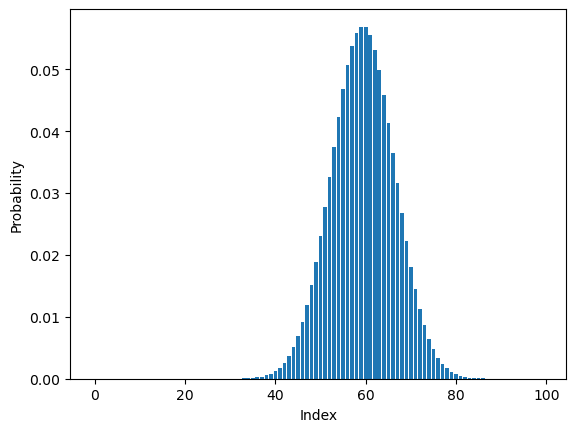

In [3]:
X = th.linspace(0., 10., 100).view(-1, 1)
x = th.tensor([[6]])
w = weights(x.view(-1), X, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.bar(range(X.shape[0]), w)
plt.ylabel('Probability')
plt.xlabel('Index')
plt.show()

----

In [4]:
def htoy(h, P, Y, sim, norm):
    w = weights(h, P, sim=sim, norm=norm).view(-1, 1)
    assert w.shape[0] == Y.shape[0] == P.shape[0]
    y = (w * Y).sum(dim=0)
    return y

### Reality check
----

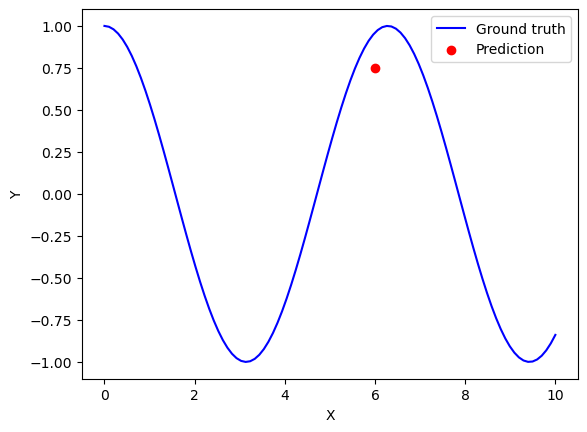

In [5]:
Y = th.cos(X)
y_pred = htoy(x.view(-1), X, Y, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.plot(X.view(-1), Y.view(-1), color='blue', label='Ground truth')
plt.scatter(x.view(-1), y_pred.view(-1), color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

----

In [6]:
def soft_nearest_neighbors(X, X_support, Y_support, enc, sim, norm = lambda k: k):
    XX = th.cat([X, X_support], dim=0)
    HP = enc(XX)
    H = HP[:X.shape[0]]
    P = HP[X.shape[0]:]
    return vmap(lambda h: htoy(h, P, Y_support, sim=sim, norm=norm))(H)

### Reality check
----

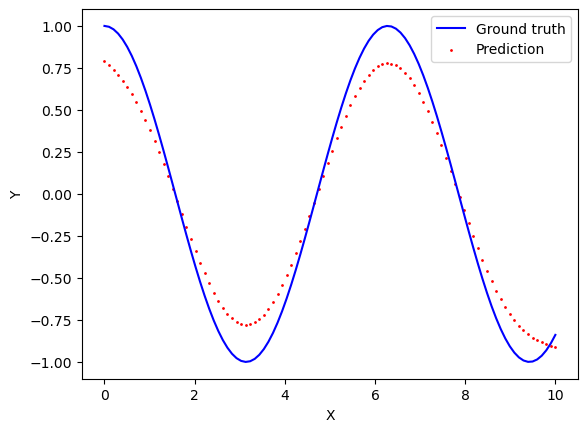

In [7]:
Y_pred = soft_nearest_neighbors(X, X, Y, enc=lambda x: x, sim=lambda a, b: -(a - b) ** 2, norm=lambda k: k)
plt.plot(X.view(-1), Y.view(-1), color='blue', label='Ground truth')
plt.scatter(X.view(-1), Y_pred.view(-1), color='red', label='Prediction', s=1.)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [8]:
class SoftNN(nn.Module):
    def __init__(self, encoder, support = None, similarity = th.dot, normalizer = lambda k: k):
        super().__init__()
        self._enc = encoder
        self._sim = similarity
        self._norm = normalizer
        self._X, self._Y = (None, None) if support is None else support
        assert self._X.shape[0] == self._Y.shape[0] or (self._X is None and self._Y is None)

    @property
    def support(self):
        assert self._X is not None and self._Y is not None
        return self._X, self._Y

    @support.setter
    def support(self, value):
        self._X, self._Y = value
        assert self._X.shape[0] == self._Y.shape[0]

    def forward(self, x):
        return soft_nearest_neighbors(X=x,
                                      X_support=self._X,
                                      Y_support=self._Y,
                                      enc=self._enc,
                                      sim=self._sim,
                                      norm=self._norm)

----

# Encoder definition & SoftNN declaration
----
----

In [9]:
class Dense(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.linear = nn.Linear(in_size, hidden_size)

    def forward(self, x):
        h = self.linear(x)
        return th.cat([x, h], dim=1)

In [10]:
encoder = nn.Sequential(nn.BatchNorm1d(1), Dense(1, 10), nn.Mish(),
                        nn.BatchNorm1d(11), Dense(11, 11), nn.Mish(),
                        nn.BatchNorm1d(22), Dense(22, 22), nn.Mish(),
                        nn.BatchNorm1d(44), Dense(44, 44), nn.Mish(),
                        nn.BatchNorm1d(88), Dense(88, 88), nn.Mish(),
                        nn.BatchNorm1d(176), nn.Linear(176, 1))

# Problem definition
----
----

In [11]:
def generate_data(f, N, x_min=-1, x_max=1):
    X = th.rand(N, 1) * (x_max - x_min) + x_min
    Y = f(X)
    return X, Y

In [12]:
class DatasetWrapper(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [13]:
# Domain and function
x_min = 0.; x_max = 10.; resolution = 1000
X_domain = th.linspace(x_min, x_max, resolution).view(-1, 1)
fn = lambda x: th.sin(x)

### Sample support dataset
----

In [14]:
# Support dataset
X_support, Y_support = generate_data(fn, 100, x_min, x_max)

----

### Sample training dataset
----

In [15]:
# Training dataset
X_training, Y_training = generate_data(fn, 100, x_min, x_max)

----

# Model fitting (with bootstrapping)
----
----

In [16]:
def normalize(x):
    return x / x.flatten().shape[0]

In [17]:
def similarity(a, b):
    return th.dot(a, b)

In [18]:
soft_nn = SoftNN(encoder, support=(X_support, Y_support), similarity=similarity, normalizer=normalize)

# Bootstrapping
----

In [19]:
def bootstrap(model: SoftNN, data, epoch_split, optim, criterion, epochs):
    X_all, Y_all = data
    for epoch in range(epochs):
        # Split epoch data into support and training.
        idx = th.randperm(X_all.shape[0])
        top = int(idx.shape[0] * epoch_split)
        assert top < X_all.shape[0], 'No data left for evaluation.'
        assert top > 0, 'No support data.'
        model.support = (X_all[:top], Y_all[:top])
        X, Y = (X_all[top:], Y_all[top:])
        # Gradient descent step.
        optim.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optim.step()
        clear_output(wait=True)
        print('Epoch [%d], Loss: %.6f' % (epoch + 1, loss))

### Optimize
----

In [20]:
soft_nn.train(mode=True)
bootstrap(soft_nn, (X_training, Y_training), 0.5, Rprop(encoder.parameters()), F.mse_loss, 1000)
soft_nn.train(mode=False);

Epoch [1000], Loss: 0.000005


----

Loss: 0.062408


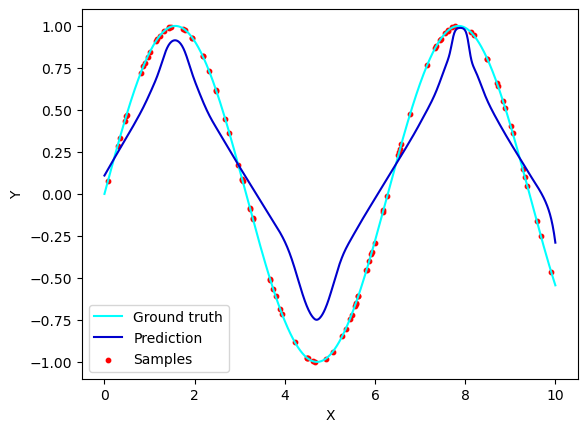

In [21]:
# Select dataset to use as support.
#X_data, Y_data = (X_support, Y_support)
X_data, Y_data = (X_training, Y_training)
soft_nn.support = (X_data, Y_data)
# Sample ground truth.
X = th.linspace(x_min, x_max, resolution).view(-1, 1)
Y = fn(X)
# Sample predictions.
Y_pred = soft_nn(X).detach()
# Plot everything.
plt.plot(X.view(-1), Y.view(-1), color='cyan', label='Ground truth')
plt.plot(X.view(-1), Y_pred.view(-1), color='mediumblue', label='Prediction')
plt.scatter(X_data.view(-1), Y_data.view(-1), label='Samples', color='red', s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
print('Loss: %.6f' % F.mse_loss(Y_pred, Y))
plt.show()

# Notes:

- If $\kappa(a, b) \rightarrow \mathbb{R}$, with dot-product similarity, and $f(x) \rightarrow \mathbb{R}$, then the model performs worse when the support is larger than the training data. The same is true when the support is smaller than the training data, but there seems to be a larger margin for the second case.
- The resulting distance metric is agnostic to the support set. That means the support set can be replaced by another set of samples of approximately the same size without change in performance.

### Improving performance...?

The approach being tested here is the bootstrapping of the support set in order to learn a suitable metric. What would happen if one fixes the distance metric and instead learns a mapping from input space X to some latent space Z via an autoencoder trained jointly for reconstruction accuracy and predictive accuracy?